In [38]:
include("../code/julia/ha-trade-environment.jl")

include("../code/julia/ha-trade-solution.jl") #in here is the ``world_equillibrium'' function

include("../code/julia/ha-trade-helper-functions.jl") #in there is the ``aggregate'' function

include("../code/julia/static-trade-environment.jl")
using MINPACK
using FiniteDifferences
using Plots
using CSV
using DataFrames

In [162]:
Ncntry = 4
γ = 2.0


dtest = 2.0
d = dtest.*ones(Ncntry,Ncntry)
d[diagind(d)] .= 1.0

TFP = [1.0, 1.0, 0.75, 1.25] 
#here there is a rich and a poor country

mdl_prm = world_model_params(Ncntry = Ncntry, Na = 100, Nshocks = 5, 
γ = γ , ϕ = 3, amax = 8.0, σ = 0.15, ρ = 0.90, σϵ = 0.25, d = d, TFP = TFP)

@unpack Na, Nshocks, Ncntry, TFP = mdl_prm

R = 1.03*ones(Ncntry);
W = 1.0*ones(Ncntry);

In [163]:
f(x) = world_equillibrium(x, mdl_prm, hh_solution_method = "itteration");

function f!(fvec, x)

    fvec .= f(x)

end

initial_x = [W[2:end]; R]

n = length(initial_x)
diag_adjust = n - 1

sol = fsolve(f!, initial_x, show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-5,
       )

print(sol)

Wsol = [1.0; sol.x[1:Ncntry-1]]
Rsol = sol.x[Ncntry:end]

Y, tradeflows, A_demand, tradeshare, hh, dist = world_equillibrium(Rsol, Wsol, mdl_prm, hh_solution_method = "itteration");

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.856335e+00     0.000000e+00         0.862000
     2     2.532355e-01     3.291274e-02         7.102000
     3     7.464226e-02     2.377769e-03         0.900000
     4     8.297719e-03     5.350638e-04         0.926000
     5     2.892647e-03     9.099911e-07         0.907000
     6     7.479245e-04     2.483055e-08         0.904000
     7     6.982639e-05     2.759168e-09         0.912000
     8     9.364954e-06     2.533766e-11         0.926000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [1.0, 1.0, 1.0, 1.03, 1.03, 1.03, 1.03]
 * Zero: [1.000000406599107, 0.8309283562077734, 1.1507854604369647, 1.0209042218637336, 1.020904182944762, 1.022055781365963, 1.0201006853409464]
 * Inf-norm of residuals: 0.000009
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most t

In [164]:
tradeshare

4×4 Matrix{Float64}:
 0.806737   0.0634877  0.0421697  0.0876057
 0.0634879  0.806737   0.0421697  0.0876057
 0.0504209  0.0504208  0.823887   0.0752708
 0.0763647  0.0763646  0.0538739  0.793397

In [165]:
dtest = 2.00.*0.95
d = dtest.*ones(Ncntry,Ncntry)
d[diagind(d)] .= 1.0

mdl_prm = world_model_params(Ncntry = Ncntry, Na = 100, Nshocks = 5, 
γ = γ , ϕ = 3, amax = 8.0, σ = 0.15, ρ = 0.90, σϵ = 0.25, d = d, TFP = TFP)

f(x) = world_equillibrium(x, mdl_prm, hh_solution_method = "itteration");

function f!(fvec, x)

    fvec .= f(x)

end

initial_x = [W[2:end]; R]

n = length(initial_x)
diag_adjust = n - 1

sol = fsolve(f!, initial_x, show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-5,
       )

print(sol)

Wsol = [1.0; sol.x[1:Ncntry-1]]
Rsol = sol.x[Ncntry:end]

Yp, tradeflowsp, A_demandp, tradesharep, hhp, distp = world_equillibrium(Rsol, Wsol, mdl_prm, hh_solution_method = "itteration");

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.895588e+00     0.000000e+00         0.878000
     2     2.580065e-01     3.695980e-02         6.724000
     3     8.263740e-02     2.136657e-03         0.885000
     4     7.911642e-03     4.795296e-04         0.919000
     5     2.468506e-03     7.650808e-07         0.896000
     6     6.284794e-04     1.192171e-08         0.955000
     7     8.722017e-05     7.578938e-10         0.890000
     8     1.348637e-05     1.341590e-11         0.882000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [1.0, 1.0, 1.0, 1.03, 1.03, 1.03, 1.03]
 * Zero: [1.0000001289394391, 0.8272631515394652, 1.1548051782230933, 1.0209659708775372, 1.0209659461883447, 1.0221590824334152, 1.0201261345612744]
 * Inf-norm of residuals: 0.000013
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at mos

In [166]:
tradesharep

4×4 Matrix{Float64}:
 0.777419   0.0732888  0.0497121  0.0995799
 0.0732889  0.777419   0.0497121  0.0995799
 0.0597093  0.0597093  0.792996   0.0875855
 0.0865052  0.0865052  0.0621945  0.764795

In [167]:
welfare = 100.0 .*(log_sum_column(hh[1].Tv, mdl_prm.σϵ) - log_sum_column(hhp[1].Tv, mdl_prm.σϵ))./ log_sum_column(hh[1].Tv, mdl_prm.σϵ)  

100×5 Matrix{Float64}:
 0.144972  0.282196  0.571888  1.0099   1.5557
 0.151688  0.291972  0.581249  1.0176   1.56321
 0.157932  0.300513  0.58871   1.0257   1.5707
 0.163934  0.308416  0.596864  1.03365  1.57818
 0.170117  0.315931  0.604891  1.04159  1.58564
 0.175997  0.323243  0.612978  1.0495   1.59309
 0.181731  0.330447  0.621043  1.05744  1.60051
 0.187398  0.338015  0.628992  1.06536  1.60792
 0.19304   0.345432  0.636891  1.07325  1.61532
 0.198692  0.352763  0.644756  1.08112  1.6227
 0.204355  0.360062  0.652618  1.08902  1.6301
 0.209999  0.367282  0.66049   1.09689  1.63748
 0.215668  0.374475  0.66834   1.10474  1.64484
 ⋮                                      
 0.726301  0.933067  1.24847   1.67471  2.13326
 0.73361   0.94047   1.25591   1.68181  2.13752
 0.740921  0.947873  1.26334   1.68886  2.14186
 0.748179  0.955289  1.27077   1.69588  2.14649
 0.755419  0.962735  1.27819   1.70286  2.15103
 0.76266   0.970177  1.2856    1.70978  2.15547
 0.76995   0.977617  1.29302

In [169]:
((.77 / .806).^-.25 - 1)*100

1.1488802037870727

In [168]:
100*(sum( vec(log_sum_column(hh[1].Tv, mdl_prm.σϵ)).* dist[1].λ ) 
    - sum( vec(log_sum_column(hhp[1].Tv, mdl_prm.σϵ)).* distp[1].λ )) / sum( vec(log_sum_column(hhp[1].Tv, mdl_prm.σϵ)).* distp[1].λ )

0.7122465317983306

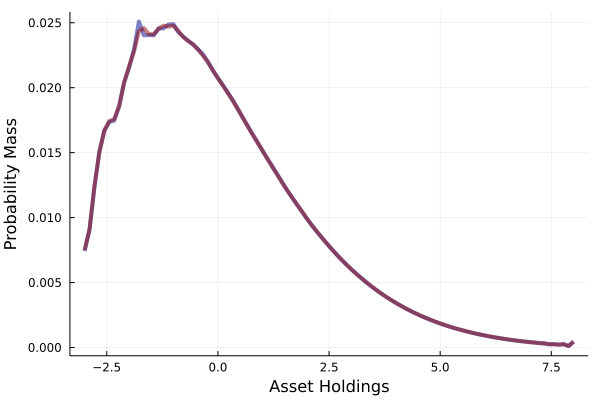

In [47]:
adist = get_distribution(dist[1].state_index, dist[1].λ);

plot(mdl_prm.agrid, adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)

adistp = get_distribution(dist[1].state_index, distp[1].λ);

plot!(mdl_prm.agrid, adistp, alpha = 0.5, lw = 4,
    color = "dark red", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)

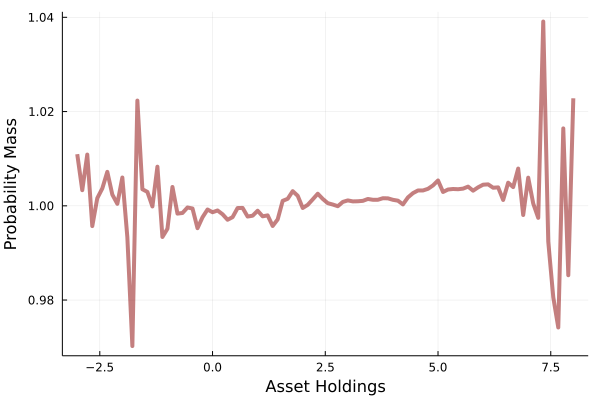

In [48]:
plot(mdl_prm.agrid, adistp./adist, alpha = 0.5, lw = 4,
    color = "dark red", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)